# Introduction
Machine learning competitions are a great way to improve your data science skills and measure your progress. 

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this course.
The link to the competition is https://www.kaggle.com/c/home-data-for-ml-course/overview

The steps in this notebook are:
1. Build a Random Forest model with all of your data (**X** and **y**)
2. Read in the "test" data, which doesn't include values for the target.  Predict home values in the test data with your Random Forest model.
3. Submit those predictions to the competition and see your score.
4. Optionally, come back to see if you can improve your model by adding features or changing your model. Then you can resubmit to see how that stacks up on the competition leaderboard.

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path)
home_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [36]:
y = home_data.SalePrice
updated_features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'TotalBsmtSF', 'GarageCars', 'OverallCond',
                    'OverallQual', 'KitchenQual', 'Neighborhood', 'CentralAir', 'LowQualFinSF', 'Condition2']
one_hot_encoded_training = pd.get_dummies(home_data[updated_features])
X = SimpleImputer().fit_transform(one_hot_encoded_training)

train_X, val_X, train_y, val_y = train_test_split(one_hot_encoded_training, y, test_size=0.2, random_state=1)

# Partial Dependence Plots

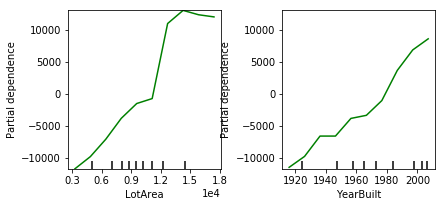

In [37]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

gb_model = GradientBoostingRegressor()
gb_model.fit(X,y)
my_plots = plot_partial_dependence(gb_model, features=[0,1], X=X,
                                   feature_names=['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 
                                                  'TotalBsmtSF', 'GarageCars', 'OverallCond', 'OverallQual', 
                                                  'Neighborhood', 'CentralAir'], grid_resolution=10)

# Compare Different Models with Train Test Split

In [38]:
iowa_model = DecisionTreeRegressor(random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

iowa_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

gb_model = GradientBoostingRegressor(random_state=1)
gb_model.fit(train_X, train_y)
gb_val_predictions = gb_model.predict(val_X)
gb_val_mae = mean_absolute_error(gb_val_predictions, val_y)
print("Validation MAE for Gradient Boosting: {:,.0f}".format(gb_val_mae))

Validation MAE when not specifying max_leaf_nodes: 25,176
Validation MAE for best value of max_leaf_nodes: 24,898
Validation MAE for Random Forest Model: 18,190
Validation MAE for Gradient Boosting: 16,634


# Pipeline And Cross Validation

In [39]:
xg_pipeline = make_pipeline(SimpleImputer(), XGBRegressor(n_estimators=300, learning_rate=0.1))
xg_pipeline.fit(train_X, train_y)
xg_predictions = xg_pipeline.predict(val_X)
xg_val_mae = mean_absolute_error(xg_predictions, val_y)
print("MAE for XGBoost with Train Test Tplit: {:,.0f}".format(xg_val_mae))

scores = cross_val_score(xg_pipeline, X, y, scoring='neg_mean_absolute_error')
print(scores)
print('MAE for XGBoost with Cross Validation %2f' %(-1 * scores.mean()))

#xg_model = XGBRegressor(n_estimators=300, learning_rate=0.1)
#xg_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(train_X, train_y)], verbose=False)
#xg_val_predictions = xg_model.predict(val_X)
#xg_val_mae1 = mean_absolute_error(xg_val_predictions, val_y)

MAE for XGBoost with Train Test Tplit: 16,089
[-16578.62449467 -18394.61899224 -15986.84720615]
MAE for XGBoost with Cross Validation 16986.696898


# Align Training and Test Sets

In [40]:
test_data_path = 'test.csv'
test_data = pd.read_csv(test_data_path)

one_hot_encoded_test = pd.get_dummies(test_data[updated_features])
final_train, final_test = one_hot_encoded_training.align(one_hot_encoded_test, join='inner', axis=1)

# Make Predictions

In [41]:
xg_on_full_data = XGBRegressor(n_estimators=300, learning_rate=0.1)
xg_on_full_data.fit(final_train, y)
test_preds = xg_on_full_data.predict(final_test)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)